### Run multiple models on different GPUs with the same data
This is very useful when you want to compare your hyper-parameters / models without set seed.
Set seed method has several drawbacks  

1) Time costly <br>
2) RAM memory costly <br>
3) when encounter data augmentation, you will get in trouble... fix augmentation is very annoying. (I'll make the data pipeline to accomplish when I got time to work on this...) <br>

In [1]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', default="1,2", type = str, help = "depends on how many GPUs on your machine and which GPU you want to get")
parser.add_argument('--frame_work', default="Keras", type = str, help = "TF / Keras")
parser.add_argument('--use_data', default="mnist", type = str, help = "mnist / cifar10")
parser.add_argument('--epoch', default= 100, type = int)
parser.add_argument('--batch_size', default= 256, type = int)

FLAGS = parser.parse_args([])
print(FLAGS)

os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu_id
import threading
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import cifar10, cifar100
from keras.utils.np_utils import to_categorical

import keras.backend as K
from keras.models import Model, load_model, save_model
from keras.layers import Dense, Activation, Input, Conv2D, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.optimizers import SGD
# Modified from source: https://stackoverflow.com/questions/46712272/run-hyperparameter-optimization-on-parallel-gpus-using-tensorflow
# The original version IS NOT CORRECT, you have to add with tf.devices inside the graph

Namespace(batch_size=256, epoch=100, frame_work='Keras', gpu_id='1,2', use_data='mnist')


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Define a callback for Keras model
from keras.callbacks import Callback
class K_Logger(Callback):
    def __init__(self, n, gpu_id = 0):
        self.n = n   # print loss & acc every n epochs
        self.gpu_id = gpu_id

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            # add what you need here
            train_loss = logs.get('loss')
            train_acc = logs.get('acc')
            valid_loss = logs.get('val_loss')
            valid_acc = logs.get('val_acc')
            print("GPU_ID: %s, epoch: %4d, loss: %0.5f, acc: %0.3f, val_loss: %0.5f, val_acc: %0.3f" \
                  % (self.gpu_id, epoch, 
                     train_loss, train_acc,
                     valid_loss, valid_acc))
            
class TF_Logger():
    def __init__(self, n, gpu_id = 0):
        self.n = n
        self.gpu_id = gpu_id
        # append what you need here
        self.history = {'loss': [],
                        'acc': [],
                        'val_loss': [],
                        'val_acc': []}
        
    def update(self, epoch, loss, acc, val_loss, val_acc):
        self.history['loss'].append(loss)
        self.history['acc'].append(acc)
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        
        if epoch % self.n == 0:
            print("GPU_ID: %s, epoch: %4d, loss: %0.5f, acc: %0.3f, val_loss: %0.5f, val_acc: %0.3f" \
                  % (self.gpu_id, epoch, 
                     loss, acc,
                     val_loss, val_acc))

### Check GPU ID get

In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# list them, no matter which GPU you pick up, the order must start from 0 (e.g. CUDA_VISIBLE_DEVICES=7 ==> /device:GPU:0)
get_available_gpus()

['/device:GPU:0', '/device:GPU:1']

In [4]:
# Get the data
use_data = FLAGS.use_data

if use_data is 'mnist':
    dset = input_data.read_data_sets("data/mnist", one_hot=True, reshape=False)
    train_x_all = dset.train.images
    train_y_all = dset.train.labels
    test_x = dset.test.images
    test_y = dset.test.labels
elif use_data is 'cifar10':
    dtrain, dtest = cifar10.load_data()
    train_x_all, train_y_all = dtrain
    test_x, test_y = dtest
    train_y_all = to_categorical(train_y_all, num_classes=10)
    test_y = to_categorical(test_y, num_classes=10)
    
print(train_x_all.shape)
print(train_y_all.shape)
print(test_x.shape)
print(test_y.shape)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
(55000, 28, 28, 1)
(55000, 10)
(10000, 28, 28, 1)
(10000, 10)


In [5]:
def build_keras_model(input_shape, n_classes):
    # Example for a simple model
    x_in = Input(shape = input_shape)
    x = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x_in)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Flatten()(x)
    y = Dense(units=n_classes, activation='softmax')(x)
    
    model = Model(inputs=[x_in], outputs=[y])
    
    return model

def build_tf_model(input_shape, n_classes):
    imd1, imd2, imd3 = input_shape
    x = tf.placeholder(tf.float32, [None, imd1, imd2, imd3], name='x')
    y = tf.placeholder(tf.float32, [None, n_classes], name='y')
    
    x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=(3,3), padding='same')
    x = tf.nn.relu(x)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=(2,2), strides=(1,1))
    
    x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=(3,3), padding='same')
    x = tf.nn.relu(x)
    x = tf.layers.max_pooling2d(inputs=x, pool_size=(2,2), strides=(1,1))
    
    x = tf.layers.flatten(inputs=x)
    pred = tf.layers.dense(inputs=x, units=n_classes)
    pred = tf.nn.softmax(pred)
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1), 
                          name='cost')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred, 1), 
                                               tf.argmax(y, 1)), 
                                      tf.float32), name = 'accuracy')
    return cost

In [6]:
# Define the graphs per device
learning_rates = [0.01, 0.001]
jobs = []
devices = ['/device:GPU:0', '/device:GPU:1'] # depends on which GPUs you want to put them in

# Note, the optimization part was put at different place for Tensorflow and Keras version.
# For tensorflow, optimize should be placed inside tf.device (or it seems gpus not working correctly)
# For Keras, optim and compile should be placed outside tf.device (or it will throw gradient collection error)

if FLAGS.frame_work is "TF":
    for device, learning_rate in zip(devices, learning_rates):
        with tf.Graph().as_default() as graph:
            with tf.device(device):
                cost = build_tf_model(input_shape = train_x_all.shape[1:], n_classes=train_y_all.shape[1] )
                optimize = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, name='optimize')
        jobs.append(graph)
        
elif FLAGS.frame_work is "Keras":
    for learning_rate, device in zip(learning_rates, devices):
        with tf.Graph().as_default() as graph:
            with tf.device(device):
                model = build_keras_model(input_shape=(train_x_all.shape[1:]), n_classes=train_y_all.shape[1])
            # to cpu
            optim = SGD(lr=learning_rate)
            model.compile(loss = 'categorical_crossentropy', metrics= ['acc'], optimizer=optim)
        jobs.append([graph, model])
        
print(jobs)

[[<tensorflow.python.framework.ops.Graph object at 0x7fe2ae4ad1d0>, <keras.engine.training.Model object at 0x7fe2a9c81710>], [<tensorflow.python.framework.ops.Graph object at 0x7fe2ae4adda0>, <keras.engine.training.Model object at 0x7fe2a9b5a518>]]


In [7]:
# Train a graph on a device
n_epoch = FLAGS.epoch
batch_size = FLAGS.batch_size

if FLAGS.frame_work is "TF":
    def train(device, graph):
        graph.history = TF_Logger(n = 5, gpu_id = device)
        print("Start training on %s" % device)
        with tf.Session(graph=graph) as session:
            total_batch = int(train_x_all.shape[0] / batch_size)
            total_val_step = int(test_x.shape[0] / batch_size)
            
            x = graph.get_tensor_by_name('x:0')
            y = graph.get_tensor_by_name('y:0')
            cost_op = graph.get_tensor_by_name('cost:0')
            accuracy_op = graph.get_tensor_by_name('accuracy:0')
            optimize_op = graph.get_operation_by_name('optimize')
            
            session.run(tf.global_variables_initializer())
            print("Start Running")
            for epoch in range(n_epoch):
                epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc = [], [], [], []
                for i in range(total_batch):
                    batch_x = train_x_all[i * batch_size:(i + 1) * batch_size]
                    batch_y = train_y_all[i * batch_size:(i + 1) * batch_size]
                    
                    _, loss, acc = session.run([optimize_op, cost_op, accuracy_op], 
                                                feed_dict={x: batch_x, y: batch_y})
                    
                    epoch_loss.append(loss)
                    epoch_acc.append(acc)
                    
                epoch_loss = np.mean(epoch_loss)
                epoch_acc = np.mean(epoch_acc)
                
                for i in range(total_val_step):
                    batch_x = test_x[i * batch_size:(i + 1) * batch_size]
                    batch_y = test_y[i * batch_size:(i + 1) * batch_size]
                    
                    val_loss, val_accuracy = session.run([cost_op, accuracy_op], 
                                                         feed_dict={x: batch_x, y: batch_y})
                    epoch_val_loss.append(val_loss)
                    epoch_val_acc.append(val_accuracy)
                    
                epoch_val_loss = np.mean(epoch_val_loss)
                epoch_val_acc = np.mean(epoch_val_acc)
                    
                # Link it to logger
                graph.history.update(epoch, epoch_loss, epoch_acc, epoch_val_loss, epoch_val_acc)
                        
elif FLAGS.frame_work is "Keras":
    def train(device, graph, model):
        print("Start training on %s" % device)
        logger = K_Logger(n = 5, gpu_id = device)
        with tf.Session(graph=graph) as session:
            K.set_session(session=session)
            model.fit(x = train_x_all, 
                      y = train_y_all, 
                      batch_size=batch_size, 
                      epochs=n_epoch, 
                      verbose=0, 
                      validation_data=(test_x, test_y), callbacks=[logger])

# Start threads in parallel
train_threads = []
for i, item in enumerate(jobs):
    if FLAGS.frame_work is "TF":
        this_graph = item
        train_threads.append(threading.Thread(target=train, args=(devices[i], this_graph)))
    elif FLAGS.frame_work is "Keras":
        this_graph = item[0]
        this_model = item[1]
        train_threads.append(threading.Thread(target=train, args=(devices[i], this_graph, this_model)))
for t in train_threads:
    t.start()
for t in train_threads:
    t.join()

Start training on /device:GPU:0Start training on /device:GPU:1

GPU_ID: /device:GPU:0, epoch:    0, loss: 1.88935, acc: 0.524, val_loss: 0.92974, val_acc: 0.798
GPU_ID: /device:GPU:1, epoch:    0, loss: 2.29458, acc: 0.140, val_loss: 2.28009, val_acc: 0.198
GPU_ID: /device:GPU:0, epoch:    5, loss: 0.27579, acc: 0.919, val_loss: 0.26570, val_acc: 0.922
GPU_ID: /device:GPU:1, epoch:    5, loss: 2.07980, acc: 0.618, val_loss: 2.02535, val_acc: 0.653
GPU_ID: /device:GPU:0, epoch:   10, loss: 0.19017, acc: 0.944, val_loss: 0.17214, val_acc: 0.950
GPU_ID: /device:GPU:1, epoch:   10, loss: 1.04161, acc: 0.770, val_loss: 0.91345, val_acc: 0.804
GPU_ID: /device:GPU:0, epoch:   15, loss: 0.14132, acc: 0.959, val_loss: 0.12530, val_acc: 0.963
GPU_ID: /device:GPU:1, epoch:   15, loss: 0.55276, acc: 0.851, val_loss: 0.50719, val_acc: 0.866
GPU_ID: /device:GPU:0, epoch:   20, loss: 0.11232, acc: 0.968, val_loss: 0.10183, val_acc: 0.970
GPU_ID: /device:GPU:1, epoch:   20, loss: 0.43022, acc: 0.879, 

## Get the result and plot it

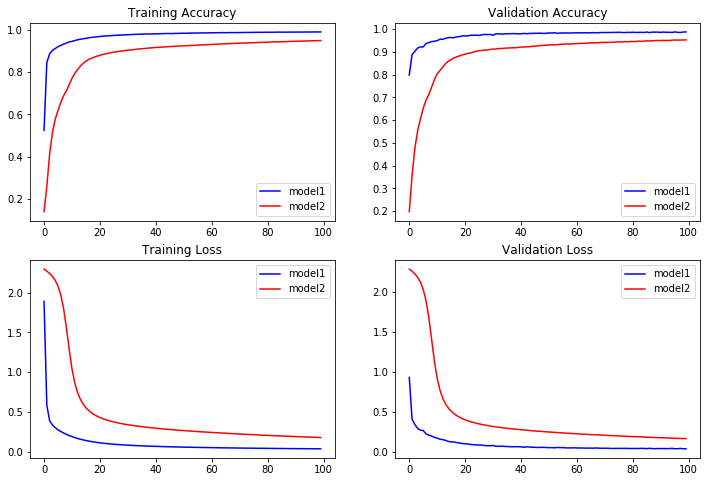

In [8]:
if FLAGS.frame_work is "TF":
    history_model1 = jobs[0].history.history
    history_model2 = jobs[1].history.history
elif FLAGS.frame_work is "Keras":
    history_model1 = jobs[0][1].history.history
    history_model2 = jobs[1][1].history.history

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(np.arange(len(history_model1['acc'])), history_model1['acc'], 'b-', label = 'model1')
plt.plot(np.arange(len(history_model2['acc'])), history_model2['acc'], 'r-', label = 'model2')
plt.legend()
plt.title("Training Accuracy")

plt.subplot(2,2,2)
plt.plot(np.arange(len(history_model1['val_acc'])), history_model1['val_acc'], 'b-', label = 'model1')
plt.plot(np.arange(len(history_model2['val_acc'])), history_model2['val_acc'], 'r-', label = 'model2')
plt.legend()
plt.title("Validation Accuracy")

plt.subplot(2,2,3)
plt.plot(np.arange(len(history_model1['loss'])), history_model1['loss'], 'b-', label = 'model1')
plt.plot(np.arange(len(history_model2['loss'])), history_model2['loss'], 'r-', label = 'model2')
plt.legend()
plt.title("Training Loss")

plt.subplot(2,2,4)
plt.plot(np.arange(len(history_model1['val_loss'])), history_model1['val_loss'], 'b-', label = 'model1')
plt.plot(np.arange(len(history_model2['val_loss'])), history_model2['val_loss'], 'r-', label = 'model2')
plt.legend()
plt.title("Validation Loss")

plt.show()